# MountainCarContinuous-v0 with PPO, Vectorized Environment


### 1. Create Vectorized Environment

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from  collections  import deque
import time
from model import Policy
from ppo import ppo_agent
from storage import RolloutStorage
from utils import get_render_func, get_vec_normalize
from envs import make_vec_envs
from parallelEnv import parallelEnv
import matplotlib.pyplot as plt
%matplotlib inline

print('gym version: ', gym.__version__)
print('torch version: ', torch.__version__)

seed = 0 
gamma=0.99
num_processes =  16 

device = torch.device("cpu")
print('device: ', device)

envs = parallelEnv('MountainCarContinuous-v0', n=num_processes, seed=seed)

## make_vec_envs -cannot find context for 'forkserver'
## forkserver is only available in Python 3.4+ and only on some Unix platforms (not on Windows).
## envs = make_vec_envs('BipedalWalker-v2', \
##                    seed + 1000, num_processes,
##                    None, None, False, device='cpu', allow_early_resets=False)

max_steps = envs.max_steps
print('max_steps: ', max_steps)

threshold = envs.threshold
print('threshold: ', threshold)
threshold = 2000
print('reassigned threshold: ', threshold)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

dir_chk = 'dir_save_test'


gym version:  0.22.0
torch version:  2.5.1+cu124
device:  cpu
max_steps:  999
threshold:  99.0
reassigned threshold:  2000


### 2. Instantiate Model, Agent and Storage

Initialize the Policy (model MLPBase), PPO Agent and Rollout Storage.

In [2]:
## model Policy uses MLPBase
# policy = Policy(envs.observation_space.shape, envs.action_space,\
#         base_kwargs={'recurrent': False})

# 修改policy
policy = Policy(envs.observation_space.shape, envs.action_space,\
        base_kwargs={'recurrent': False})

policy.to(device)

agent = ppo_agent(actor_critic=policy, ppo_epoch=16, num_mini_batch=16,\
                 lr=0.01, eps=1e-5, max_grad_norm=0.5)

rollouts = RolloutStorage(num_steps=max_steps, num_processes=num_processes, \
                        obs_shape=envs.observation_space.shape, action_space=envs.action_space, \
                        recurrent_hidden_state_size=policy.recurrent_hidden_state_size)

obs = envs.reset()
print('type obs: ', type(obs), ', shape obs: ', obs.shape)
obs_t = torch.tensor(obs)
print('type obs_t: ', type(obs_t), ', shape obs_t: ', obs_t.shape)

rollouts.obs[0].copy_(obs_t)
rollouts.to(device)


type obs:  <class 'numpy.ndarray'> , shape obs:  (16, 2)
type obs_t:  <class 'torch.Tensor'> , shape obs_t:  torch.Size([16, 2])


### 3.Save model function

In [3]:
def save(model, directory, filename, suffix):
    torch.save(model.base.actor.state_dict(), '%s/%s_actor_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic.state_dict(), '%s/%s_critic_%s.pth' % (directory, filename, suffix))
    torch.save(model.base.critic_linear.state_dict(), '%s/%s_critic_linear_%s.pth' % (directory, filename, suffix))
    torch.save(model.base, '%s/%s_model_base_%s.pth' % (directory, filename, suffix))
    torch.save(model.dist, '%s/%s_model_dist_%s.pth' % (directory, filename, suffix))
    
limits = [-300, -160, -100, -70, -50, 0, 20, 30, 40, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits)-1):
        if j > limits[i] and j < limits[i+1]:
            suf = str(limits[i+1])
            break
        
        i_last = len(limits)-1    
        if  j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf      

### 4. Train the Agent  with Vectorized Environment

In [4]:
num_updates=120
gamma = 0.99
tau=0.95
save_interval=30
log_interval= 1 

def ppo_vec_env_train(envs, agent, policy, num_processes, num_steps, rollouts):
    
    time_start = time.time()
    
    n=len(envs.ps)    
    envs.reset()
    
    # start all parallel agents
    print('Number of agents: ', n)
    envs.step([[1]*4]*n)
    
    indices = []
    for i  in range(n):
        indices.append(i)
     
    s = 0
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    for i_episode in range(num_updates):
        
        total_reward = np.zeros(n)
        timestep = 0
        
        done = False
        
        for timestep in range(num_steps):
            
            with torch.no_grad():
                value, actions, action_log_prob, recurrent_hidden_states = \
                   policy.act(
                        rollouts.obs[timestep],
                        rollouts.recurrent_hidden_states[timestep],
                        rollouts.masks[timestep])
                   
                
            obs, rewards, done, _ = envs.step(actions.cpu().detach().numpy())
            
            
            total_reward += rewards  ## this is the list by agents
                        
            # If done then clean the history of observations.
            masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
            obs_t = torch.tensor(obs)
            
            ## Add one dimnesion to tensor, 
            ## This is (unsqueeze(1)) solution for:
            ## RuntimeError: The expanded size of the tensor (1) must match the existing size...
            rewards_t = torch.tensor(rewards).unsqueeze(1)
            rollouts.insert(obs_t, recurrent_hidden_states, actions, action_log_prob, \
                value, rewards_t, masks)
                                
        avg_total_reward = np.mean(total_reward)
        scores_deque.append(avg_total_reward)
        scores_array.append(avg_total_reward)
                
        with torch.no_grad():
            next_value = policy.get_value(rollouts.obs[-1],
                            rollouts.recurrent_hidden_states[-1],
                            rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, gamma, tau)
        
        agent.update(rollouts)
        # 改动了一下update
        # agent.update(rollouts, i_episode)

        rollouts.after_update()
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        if i_episode > 0 and i_episode % save_interval == 0:
            print('Saving model, i_episode: ', i_episode, '\n')
            suf = return_suffix(avg_score)
            save(policy, dir_chk, 'we0', suf)

        
        if i_episode % log_interval == 0 and len(scores_deque) > 1:            
            prev_s = s
            s = (int)(time.time() - time_start)
            t_del = s - prev_s
            print('Ep. {}, Timesteps {}, Score.Agents: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}, \
Interval: {:02}:{:02}'\
                   .format(i_episode, timestep+1, \
                        avg_total_reward, avg_score, s//3600, s%3600//60, s%60, t_del%3600//60, t_del%60)) 
    
        if len(scores_deque) > 1 and avg_score > threshold:   
            print('Environment solved with Average Score: ',  avg_score )
            break
        
    
    return scores_array, avg_scores_array
            

In [ ]:
envs = parallelEnv('MountainCarContinuous-v0', n=num_processes, seed=seed, dense=True)
scores, avg_scores = ppo_vec_env_train(envs, agent, policy, num_processes, max_steps, rollouts)
save(model=policy,directory=dir_chk,filename='we0',suffix='pre_train')


Number of agents:  16
Ep. 1, Timesteps 999, Score.Agents: -159.81, Avg.Score: -152.39, Time: 00:00:05, Interval: 00:05
Ep. 2, Timesteps 999, Score.Agents: -172.90, Avg.Score: -159.23, Time: 00:00:08, Interval: 00:03
Ep. 3, Timesteps 999, Score.Agents: -136.59, Avg.Score: -153.57, Time: 00:00:11, Interval: 00:03
Ep. 4, Timesteps 999, Score.Agents: -162.86, Avg.Score: -155.43, Time: 00:00:13, Interval: 00:02
Ep. 5, Timesteps 999, Score.Agents: -152.47, Avg.Score: -154.93, Time: 00:00:16, Interval: 00:03
Ep. 6, Timesteps 999, Score.Agents: -152.88, Avg.Score: -154.64, Time: 00:00:19, Interval: 00:03
Ep. 7, Timesteps 999, Score.Agents: -130.90, Avg.Score: -151.67, Time: 00:00:22, Interval: 00:03
Ep. 8, Timesteps 999, Score.Agents: -143.57, Avg.Score: -150.77, Time: 00:00:24, Interval: 00:02
Ep. 9, Timesteps 999, Score.Agents: -86.43, Avg.Score: -144.34, Time: 00:00:27, Interval: 00:03
Ep. 10, Timesteps 999, Score.Agents: -143.44, Avg.Score: -144.26, Time: 00:00:29, Interval: 00:02
Ep. 11, 

In [ ]:
envs = parallelEnv('MountainCarContinuous-v0', n=num_processes, seed=seed, dense=False)
num_updates=50
gamma = 0.99
tau=0.95
save_interval=30
log_interval= 1 

def ppo_vec_env_train_critic(envs, agent, policy, num_processes, num_steps, rollouts):
    
    time_start = time.time()
    
    n=len(envs.ps)    
    envs.reset()
    
    # start all parallel agents
    print('Number of agents: ', n)
    envs.step([[1]*4]*n)
    
    indices = []
    for i  in range(n):
        indices.append(i)
     
    s = 0
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    

    for i_episode in range(num_updates):
        
        total_reward = np.zeros(n)
        timestep = 0
        
        done = False
        
        for timestep in range(num_steps):
            
            with torch.no_grad():
                value, actions, action_log_prob, recurrent_hidden_states = \
                   policy.act(
                        rollouts.obs[timestep],
                        rollouts.recurrent_hidden_states[timestep],
                        rollouts.masks[timestep])
                   
                
            obs, rewards, done, _ = envs.step(actions.cpu().detach().numpy())
            
            
            total_reward += rewards  ## this is the list by agents
                        
            # If done then clean the history of observations.
            masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done])
            obs_t = torch.tensor(obs)
            
            ## Add one dimnesion to tensor, 
            ## This is (unsqueeze(1)) solution for:
            ## RuntimeError: The expanded size of the tensor (1) must match the existing size...
            rewards_t = torch.tensor(rewards).unsqueeze(1)
            rollouts.insert(obs_t, recurrent_hidden_states, actions, action_log_prob, \
                value, rewards_t, masks)
                                
        avg_total_reward = np.mean(total_reward)
        scores_deque.append(avg_total_reward)
        scores_array.append(avg_total_reward)
                
        with torch.no_grad():
            next_value = policy.get_value(rollouts.obs[-1],
                            rollouts.recurrent_hidden_states[-1],
                            rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, gamma, tau)
        
        agent.update_critic_only(rollouts)
        # 改动了一下update
        # agent.update(rollouts, i_episode)

        rollouts.after_update()
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        if i_episode > 0 and i_episode % save_interval == 0:
            print('Saving model, i_episode: ', i_episode, '\n')
            suf = return_suffix(avg_score)
            save(policy, dir_chk, 'we0', suf)

        
        if i_episode % log_interval == 0 and len(scores_deque) > 1:            
            prev_s = s
            s = (int)(time.time() - time_start)
            t_del = s - prev_s
            print('Ep. {}, Timesteps {}, Score.Agents: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02}, \
Interval: {:02}:{:02}'\
                   .format(i_episode, timestep+1, \
                        avg_total_reward, avg_score, s//3600, s%3600//60, s%60, t_del%3600//60, t_del%60)) 
    
        if len(scores_deque) > 1 and avg_score > threshold:   
            print('Environment solved with Average Score: ',  avg_score )
            break
        
    
    return scores_array, avg_scores_array

scores, avg_scores = ppo_vec_env_train_critic(envs, agent, policy, num_processes, max_steps, rollouts)
save(model=policy,directory=dir_chk,filename='we0',suffix='value_adjust')

Number of agents:  16
Ep. 1, Timesteps 999, Score.Agents: 707.03, Avg.Score: 686.97, Time: 00:00:05, Interval: 00:05
Ep. 2, Timesteps 999, Score.Agents: 706.52, Avg.Score: 693.49, Time: 00:00:07, Interval: 00:02
Ep. 3, Timesteps 999, Score.Agents: 705.77, Avg.Score: 696.56, Time: 00:00:10, Interval: 00:03
Ep. 4, Timesteps 999, Score.Agents: 729.74, Avg.Score: 703.20, Time: 00:00:12, Interval: 00:02
Ep. 5, Timesteps 999, Score.Agents: 698.47, Avg.Score: 702.41, Time: 00:00:14, Interval: 00:02
Ep. 6, Timesteps 999, Score.Agents: 732.90, Avg.Score: 706.77, Time: 00:00:17, Interval: 00:03
Ep. 7, Timesteps 999, Score.Agents: 755.11, Avg.Score: 712.81, Time: 00:00:19, Interval: 00:02
Ep. 8, Timesteps 999, Score.Agents: 696.03, Avg.Score: 710.94, Time: 00:00:22, Interval: 00:03
Ep. 9, Timesteps 999, Score.Agents: 709.88, Avg.Score: 710.84, Time: 00:00:24, Interval: 00:02
Ep. 10, Timesteps 999, Score.Agents: 723.49, Avg.Score: 711.99, Time: 00:00:27, Interval: 00:03
Ep. 11, Timesteps 999, Scor

In [ ]:

import torch.optim as optim
agent.optimizer = optim.Adam(agent.actor_critic.parameters(), lr=0.003, eps=1e-5)
num_updates=50
scores, avg_scores = ppo_vec_env_train(envs, agent, policy, num_processes, max_steps, rollouts)
save(model=policy,directory=dir_chk,filename='we0',suffix='final')

length of scores:  50 , len of avg_scores:  50


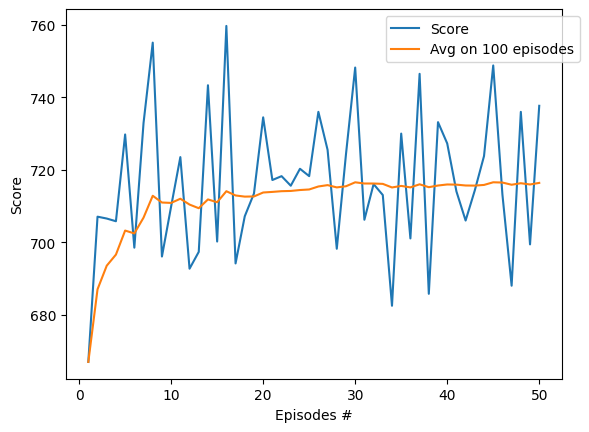

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()